In [1]:
import numpy as np
from scipy.linalg import svd, hankel, eig
from matplotlib import pyplot as plt
import scipy
from tqdm import trange
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, ExpSineSquared
import jax.numpy as jnp

In [2]:
np.random.seed(999)

In [3]:
noise = 0.001
overlap = 0.2
Tmax = 1000
dt = 1

In [4]:
def generate_samples(E, psi0, dt=1, nb=100):
    S = np.zeros(nb, dtype=np.complex128)
    
    for j in trange(nb):
        S[j] = np.sum(np.abs(psi0)**2 * np.exp(-1j * E * j * dt))
    
    return S

In [5]:
def generate_derivative_samples(E, psi0, dt=1, nb=100):
    S = np.zeros(nb, dtype=np.complex128)
    
    for j in trange(nb):
        S[j] = np.sum(np.abs(psi0)**2 * -1j * E * np.exp(-1j * E * j * dt))
    
    return S

In [6]:
def generate_2nd_derivative_samples(E, psi0, dt=1, nb=100):
    S = np.zeros(nb, dtype=np.complex128)
    
    for j in trange(nb):
        S[j] = np.sum(np.abs(psi0)**2 * -1j* -1j * E**2 * np.exp(-1j * E * j * dt))
    
    return S

In [7]:
def generate_samples_der(E, psi0, dt=1, nb=100, n=1):
    S = np.zeros(nb, dtype=np.complex128)
    
    for j in trange(nb): 
        S[j] = np.sum(np.abs(psi0)**2 * (-1j * E)**n * np.exp(-1j * E * j * dt))
    
    return S

In [8]:
def lam2lamt(lam, lammin, lammax):
    lamt = np.pi / 2 * (lam - (lammin + lammax) / 2) / (lammax - lammin)
    return lamt

In [9]:
def lamt2lam(lamt, lammin, lammax):
    lam = lamt * 2 / np.pi * (lammax - lammin) + (lammin + lammax) / 2
    return lam

In [10]:
def generate_phi(overlap, N):
    phi = np.zeros((N,1))
    phi[0] = np.sqrt(overlap)
    phi[1:] = np.sqrt((1 - phi[0]**2) / (N - 1))
    # phi[1] = np.sqrt(overlap)
    # phi[0] = np.sqrt((1 - phi[1]**2) / (N - 1))
    # phi[2:] = np.sqrt((1 - phi[1]**2) / (N - 1))
    return phi

In [11]:
data_cr2 = scipy.io.loadmat('../../data/Cr2_4000.mat')
#psiHF = data_cr2['psiHF']
E = data_cr2['E']

In [12]:
len(E)

4000

In [13]:
Et = lam2lamt(E,E[0],E[-1])

In [14]:
phi = generate_phi(overlap,len(Et))
print('generated phi')
dataS = generate_samples_der(Et,phi,dt,Tmax, n=0)

generated phi


100%|██████████| 1000/1000 [00:00<00:00, 6096.06it/s]


Text(0.5, 1.0, 'True dynamics')

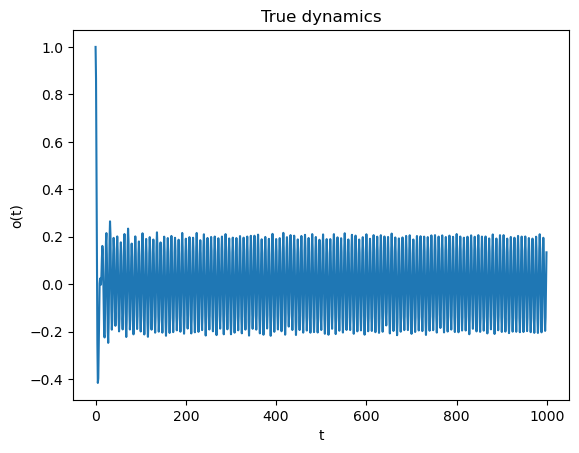

In [15]:
plt.plot(dataS.real)
plt.xlabel('t')
plt.ylabel('o(t)')
plt.title('True dynamics')

In [16]:
ddataS = generate_samples_der(Et,phi,dt,Tmax, n=1)

100%|██████████| 1000/1000 [00:00<00:00, 5709.98it/s]


Text(0.5, 1.0, 'True dynamics')

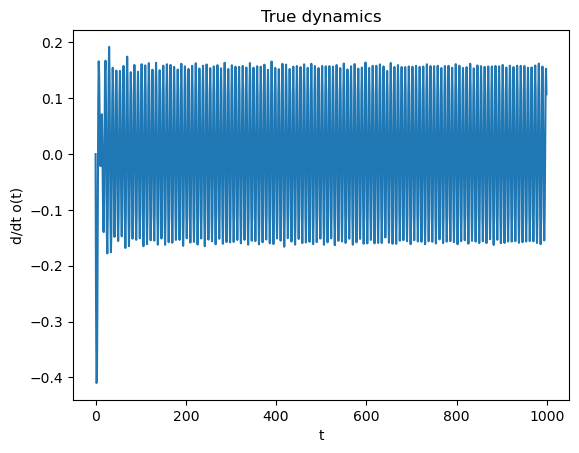

In [17]:
plt.plot(ddataS.real)
plt.xlabel('t')
plt.ylabel('d/dt o(t)')
plt.title('True dynamics')

100%|██████████| 1000/1000 [00:00<00:00, 6057.12it/s]


Text(0.5, 1.0, 'True dynamics')

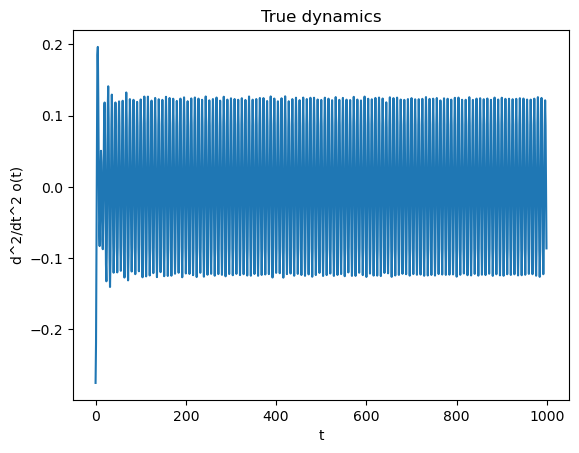

In [18]:
dddataS = generate_samples_der(Et,phi,dt,Tmax, n=2)
plt.plot(dddataS.real)
plt.xlabel('t')
plt.ylabel('d^2/dt^2 o(t)')
plt.title('True dynamics')

Text(0.5, 1.0, 'Hamiltonian spectrum')

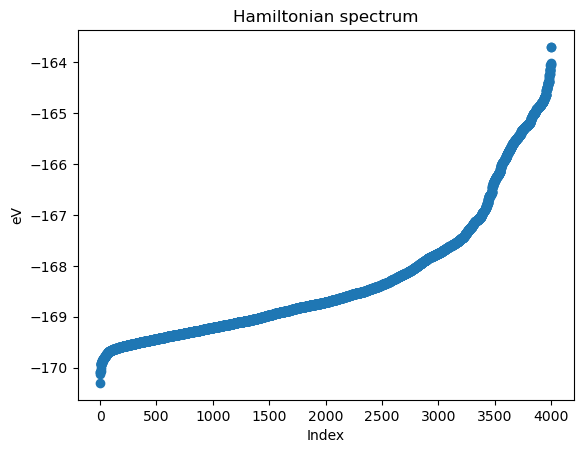

In [19]:
plt.scatter(range(0, len(E)), E)
plt.xlabel('Index')
plt.ylabel('eV')
plt.title('Hamiltonian spectrum')

In [20]:
tdataS = []
num_trajs = 100
for i in range(num_trajs):
    ndataS = (dataS + noise * np.random.randn(Tmax) + 1j * noise * np.random.randn(Tmax)).real
    tdataS.append(ndataS)

In [21]:
# n_shots = [5000, 10000, 100000, 1000000]
# avg_noisy_shots_dataS = []
# for n in n_shots:
#     noisy_shots_dataS = []
#     for i in range(num_trajs):
#         noisy_traj = np.zeros(dataS.shape)
#         var_x = []
#         for k in range(dataS.shape[0]):
#             mu = dataS[k]
#             p = (1 + mu) / 2
#             sample = np.random.binomial(n, p.real)
#             shifted_sample = 2 * sample - n
#             muapprox = (1 / n) * shifted_sample
#             noisy_traj[k] = muapprox
#         noisy_shots_dataS.append(noisy_traj)
#     avg_noisy_shots_dataS.append(np.mean(np.array(noisy_shots_dataS), axis=0))

In [22]:
# for n in range(len(n_shots)):
#     plt.plot(dataS.real)
#     plt.plot(noisy_shots_dataS[n], '--')
#     plt.title('Nshots = ' + str(n_shots[n]))
#     plt.legend(['noiseless data', 'noisy data'], frameon=False)
#     plt.ylim([-1, 1])
#     plt.xlabel('t')
#     plt.ylabel('s(t)')
#     plt.tight_layout()
#     plt.savefig('./gif_figs/LiH_dataS_nshots='+str(n_shots[n])+'.png')
#     plt.close()

In [23]:
# plt.plot(avg_noisy_shots_dataS[0])
# plt.plot(dataS.real)

In [24]:
# plt.figure(figsize=(10, 6))
# for i in range(len(n_shots[:])):
#     s_tk = noisy_shots_dataS[i]
#     N = n_shots[i]
#     rhs_l = []
#     for j in range(s_tk.shape[0]):
#         numerator = np.sqrt(1 - s_tk[j]**2)
#         denominator = np.sum(np.sqrt(1 - s_tk ** 2))
#         rhs_l.append((numerator / denominator))
#     print('Total shots spent: ', np.sum(rhs_l))
#     plt.plot( rhs_l, label=f'N = {N}')
#     #plt.plot([0, Tmax], [N / Tmax, N / Tmax], ':k')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$N \left( \frac{\sqrt{1 - s(t_k)^2}}{\sum_k \sqrt{1 - s(t_k)^2}} \right)$')
# plt.legend(frameon=False)
# plt.title('Optimal shot allocation')
# plt.savefig('optimal_shot_allocation.png')
# plt.show()

In [25]:
noisydataS = np.array(tdataS)
noisydataS.shape

(100, 1000)

In [26]:
# for i in range(noisydataS.shape[0]):
#     plt.plot(noisydataS[i, :]);
# plt.plot(dataS.real, '-', color='black', label='Noiseless observables')
# plt.xlabel('t')
# plt.ylabel('o(t)')
# plt.ylim([-1, 1])
# plt.legend()
# plt.title('Noisy observables')
# plt.savefig('noisy_data_vs_noiseless.png')

In [27]:
t = np.arange(0, Tmax, 1) * dt

In [28]:
# Average the noisy signals
average_noisy_signal = np.mean(noisydataS, axis=0)
#average_noisy_signal = avg_noisy_shots_dataS[0]

In [29]:
# Fit GP to the averaged signal
X = t[:, np.newaxis]
y = average_noisy_signal
#y = noisy_traj

In [32]:
kernel = RBF(1.0, (1e-4, 1e1))
#kernel = C(1.0) * (RBF(length_scale=1.0) + ExpSineSquared(length_scale=1.0, periodicity=1.0))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)
gp.fit(X, y)

/global/common/software/nersc/pm-2022q4/sw/pytorch/2.0.1/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=10)

In [33]:
# Predict
mean_prediction, std_prediction = gp.predict(X, return_std=True)

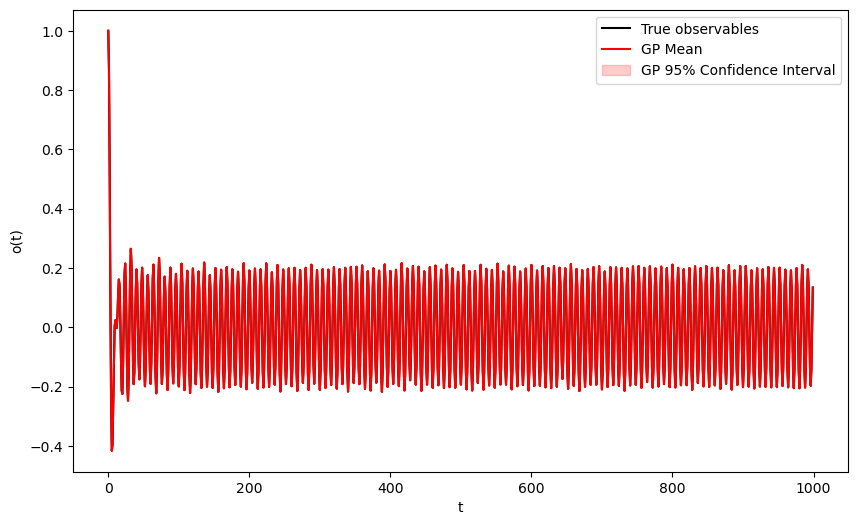

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(t, dataS.real, 'black', label='True observables')
plt.plot(t, mean_prediction, 'r-', label='GP Mean')
plt.fill_between(t, mean_prediction - 2*std_prediction, mean_prediction + 2*std_prediction, color='r', alpha=0.2, label='GP 95% Confidence Interval')
#plt.plot(t, average_noisy_signal, 'g.', alpha=0.5, label='Average Noisy Signal')
plt.xlabel('t')
plt.ylabel('o(t)')
plt.legend()
#plt.savefig('gp_denoiser_cr2.pdf')

In [35]:
np.mean(np.abs(mean_prediction - dataS.real))

8.172832983290407e-05

In [36]:
# Predict
mean_prediction_trunc, std_prediction_trunc = gp.predict(X[:250, :], return_std=True)

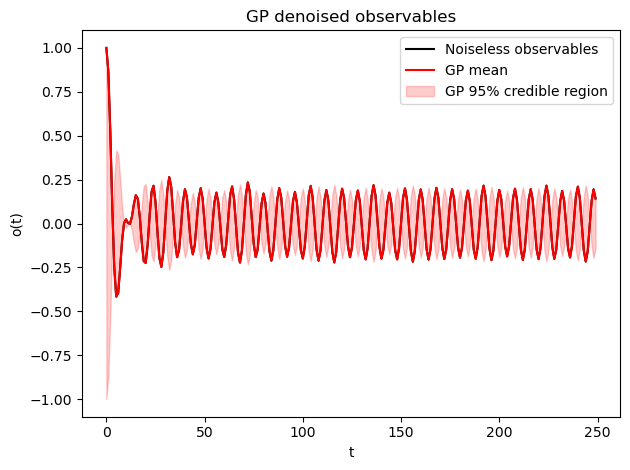

In [37]:
plt.plot(t[:250], dataS[:250].real, 'black', label='Noiseless observables')
plt.plot(t[:250], mean_prediction_trunc, 'r-', label='GP mean')
plt.fill_between(t[:250], mean_prediction_trunc - 2*mean_prediction_trunc, mean_prediction_trunc + 2*std_prediction_trunc, color='r', alpha=0.2, label='GP 95% credible region')
#plt.plot(t, average_noisy_signal, 'g.', alpha=0.5, label='Average Noisy Signal')
plt.xlabel('t')
plt.ylabel('o(t)')
plt.legend()
plt.title('GP denoised observables')
plt.tight_layout()
#plt.savefig('./gif_figs/Cr2_denoised_traj_Tmax=250_noise=1.0.png')

In [38]:
# np.linalg.norm(mean_prediction_trunc - dataS[:250].real)

In [39]:
# Predict
tpred = np.arange(0, Tmax, 1) * dt
tpred = tpred[:, np.newaxis]
mean_prediction_full, std_prediction_full = gp.predict(tpred, return_std=True)

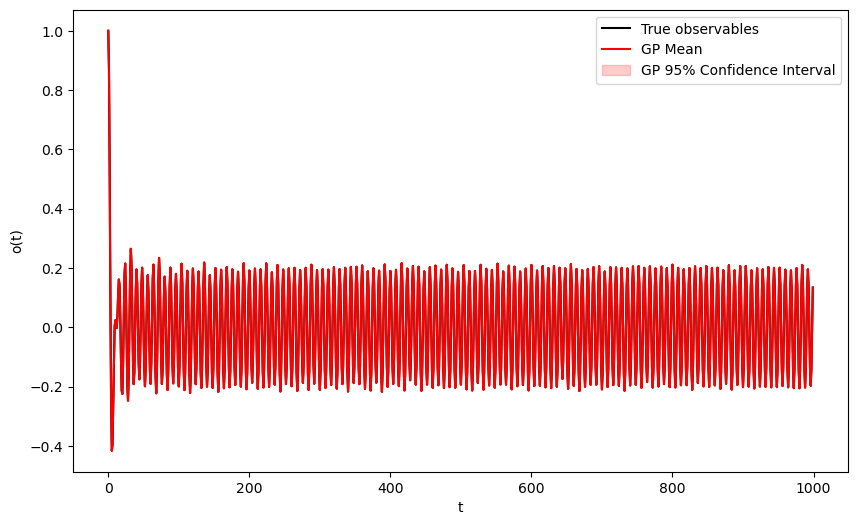

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(tpred, dataS.real, 'black', label='True observables')
plt.plot(tpred, mean_prediction_full, 'r-', label='GP Mean')
plt.fill_between(tpred.flatten(), mean_prediction_full - 2*std_prediction_full, mean_prediction_full + 2*std_prediction_full, color='r', alpha=0.2, label='GP 95% Confidence Interval')
#plt.plot(t, average_noisy_signal, 'g.', alpha=0.5, label='Average Noisy Signal')
plt.xlabel('t')
plt.ylabel('o(t)')
plt.legend()
#plt.savefig('gp_denoiser_cr2.pdf')

In [41]:
t = np.arange(0, Tmax, 1) * dt

In [42]:
# Define the RBF kernel function
def rbf_kernel(t1, t2, length_scale=1.0):
    return np.exp(-0.5 * (np.subtract.outer(t1, t2) ** 2) / length_scale**2)

In [43]:
sigma_noise = noise
computed_length_scale = gp.kernel_.length_scale

In [44]:
# Training data: Covariance matrix K (with noise term)
K = rbf_kernel(t, t, length_scale=computed_length_scale) + sigma_noise**2 * np.eye(len(t))
K_inv = np.linalg.inv(K)

In [45]:
# Define the covariance between the test points and the training points
k_star = rbf_kernel(t, t, length_scale=computed_length_scale)

In [46]:
# Implement the update formula for the predicted mean y*
y_star = k_star @ K_inv @ y 

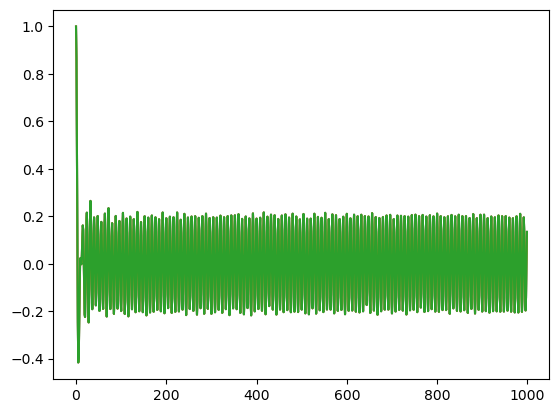

In [47]:
plt.plot(t, dataS.real)
plt.plot(t, mean_prediction)
plt.plot(t, y_star)

In [80]:
np.mean(np.abs(y_star - dataS.real)), np.mean(np.abs(mean_prediction - dataS.real)), np.mean(np.abs(y_star - mean_prediction))

(7.327938941189512e-05, 8.172832983290407e-05, 2.965456540672874e-05)

In [48]:
def rbf(z, length_scale=1.0):
    return np.exp(-0.5*(z/length_scale)**2)

In [49]:
# using Hermite polynomials
import scipy.special as ss
def drbf(n, z, l=1.0):
    herm = ss.hermite(n)
    return ((-1)**n)*((2*l**2)**(-n/2)) * herm(z/np.sqrt(2*l**2)) * rbf(z, l)

In [50]:
t1, t2 = np.meshgrid(t, t)
# set up "t1 - t2" as a vector 
t1mt2 = (-t1+t2).reshape((Tmax**2))
herm = drbf(1, t1mt2, l=computed_length_scale).reshape((Tmax, Tmax))

In [51]:
# Compute the gradient of k_star with respect to t
grad_k_star = -(t[:, None] - t[None, :]) / (computed_length_scale**2) * k_star  

In [52]:
dy_dt_star = np.dot(grad_k_star, K_inv @ y)  

In [53]:
dy_dt_star_herm = np.dot(herm, K_inv @ y)

In [54]:
#jdy_dt_star = np.dot(jacobian, K_inv @ y)  

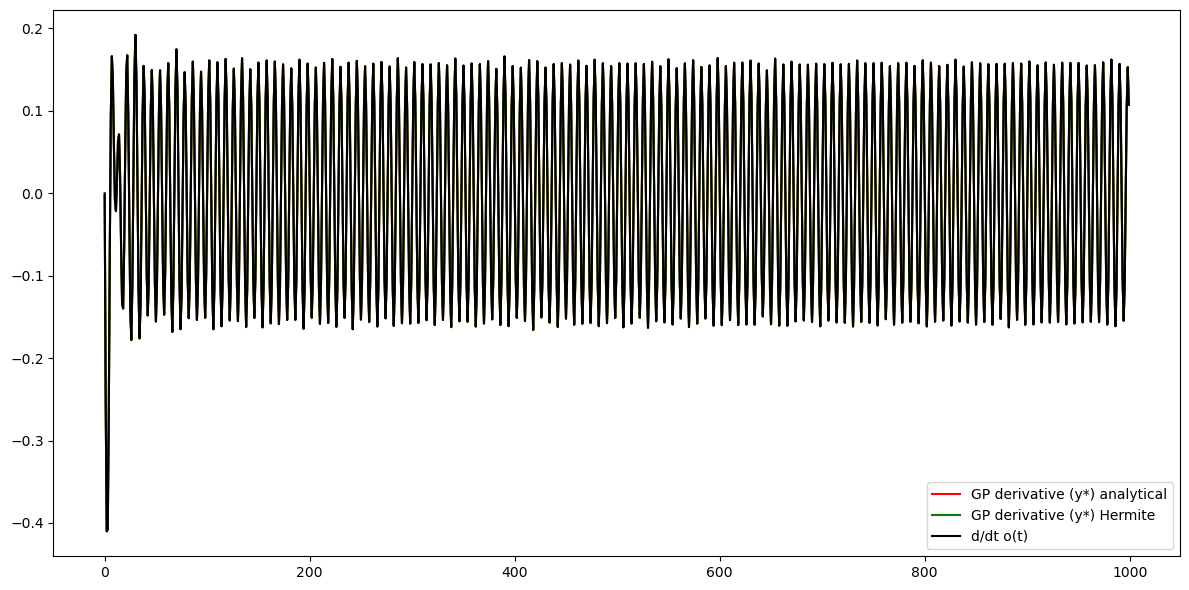

In [55]:
plt.figure(figsize=(12, 6)) 
plt.plot(t, dy_dt_star, label="GP derivative (y*) analytical", color='red')
plt.plot(t, dy_dt_star_herm, label="GP derivative (y*) Hermite", color='green')
plt.plot(t, ddataS.real, label='d/dt o(t)', color='black')
#plt.plot(t, jdy_dt_star, '--', label='jax der')
plt.legend()
plt.tight_layout()

In [79]:
np.mean(np.abs(dy_dt_star - ddataS.real))

0.00011095055443513792

In [57]:
# from scipy.io import savemat
# savemat('../../matlab/denoised_data/denoised_dataS_Cr2_GP_Tmax='+str(Tmax)+'_first_der.mat', {'denoised_dataS': dy_dt_star})

In [58]:
# Compute the second derivative of k_star with respect to t
#second_deriv_k_star = (1 / computed_length_scale**2) * (1 - (t[:, None] - t[None, :])**2 / computed_length_scale**2) * k_star
second_deriv_k_star = grad_k_star * -(t[:, None] - t[None, :]) / (computed_length_scale**2) + k_star * (-1 / computed_length_scale ** 2)
d2y_dt2_star = np.dot(second_deriv_k_star, K_inv @ y) 

In [59]:
herm2 = drbf(2, t1mt2, l=computed_length_scale).reshape((Tmax, Tmax))
d2y_dt2_star_herm = np.dot(herm2, K_inv @ y) 

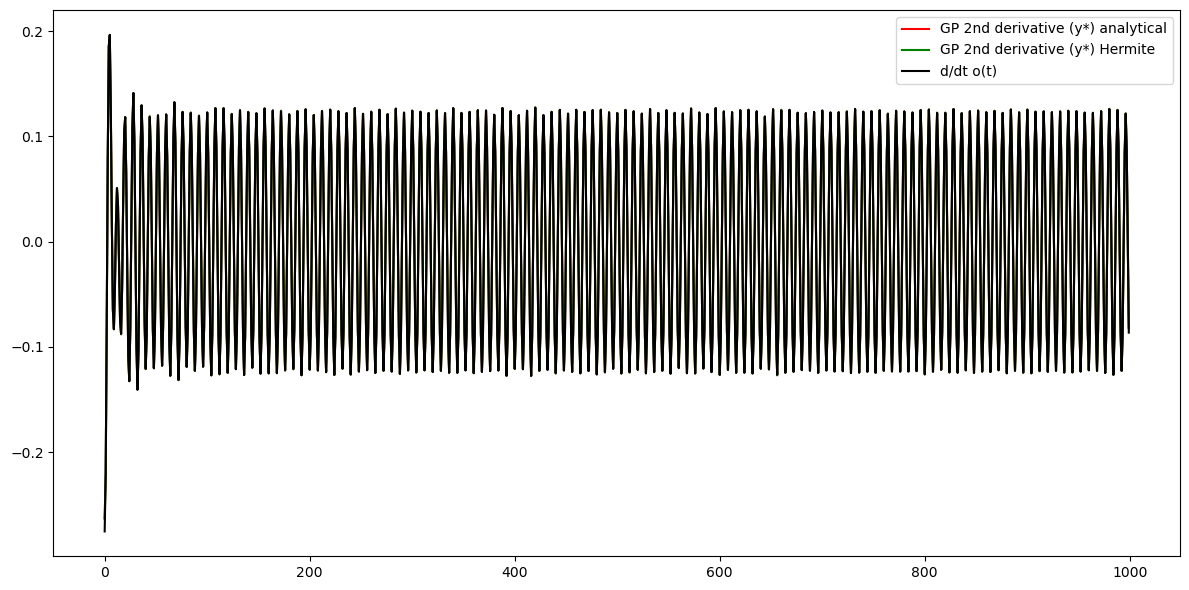

In [60]:
# Plot the results: derivative of the GP mean vs true cosine function
plt.figure(figsize=(12, 6)) 
plt.plot(t, d2y_dt2_star, label="GP 2nd derivative (y*) analytical", color='red')
plt.plot(t, d2y_dt2_star_herm, label="GP 2nd derivative (y*) Hermite", color='green')
plt.plot(t, dddataS.real, label='d/dt o(t)', color='black')
plt.legend()
plt.tight_layout()

In [61]:
np.linalg.norm(d2y_dt2_star - d2y_dt2_star_herm)

1.0211905281378562e-13

100%|██████████| 1000/1000 [00:00<00:00, 6127.37it/s]


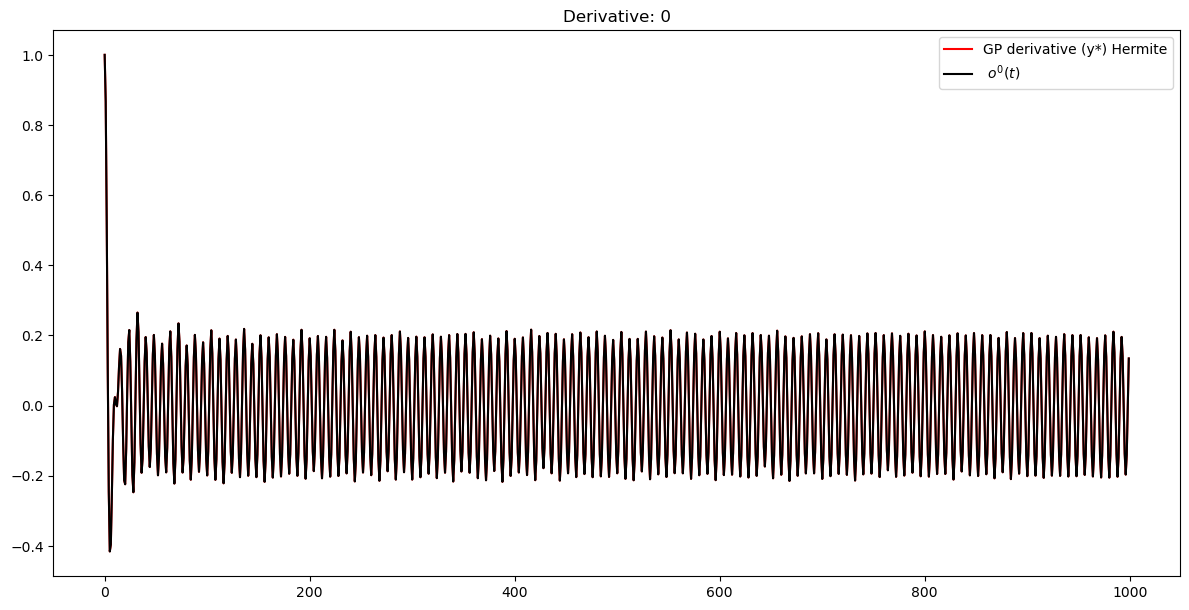

100%|██████████| 1000/1000 [00:00<00:00, 5942.51it/s]


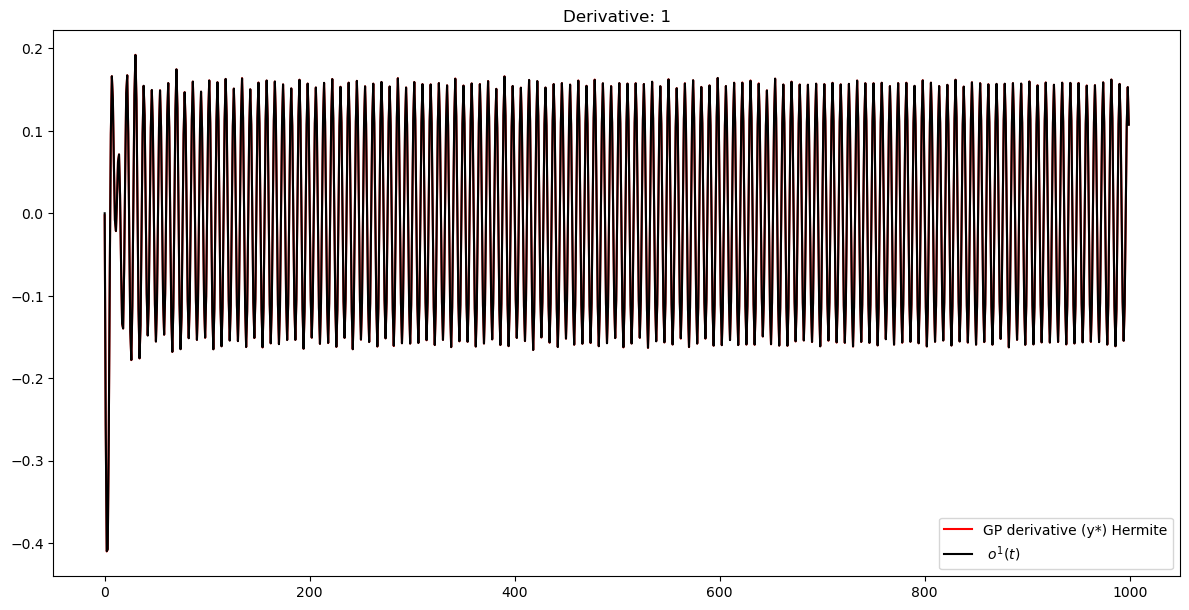

100%|██████████| 1000/1000 [00:00<00:00, 6077.11it/s]


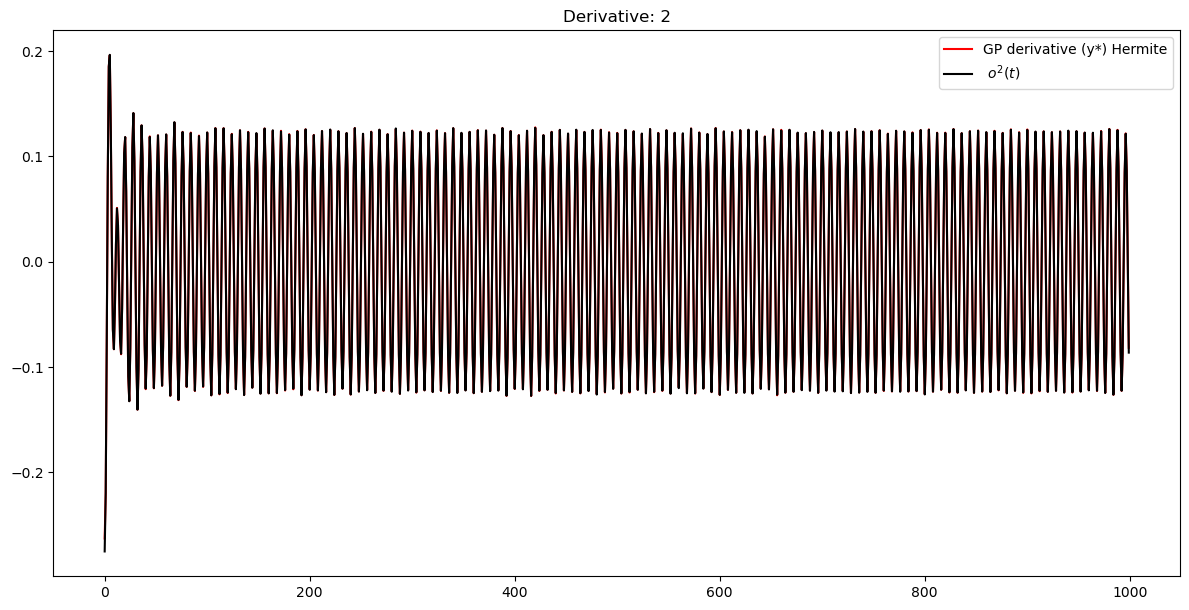

100%|██████████| 1000/1000 [00:00<00:00, 4456.47it/s]


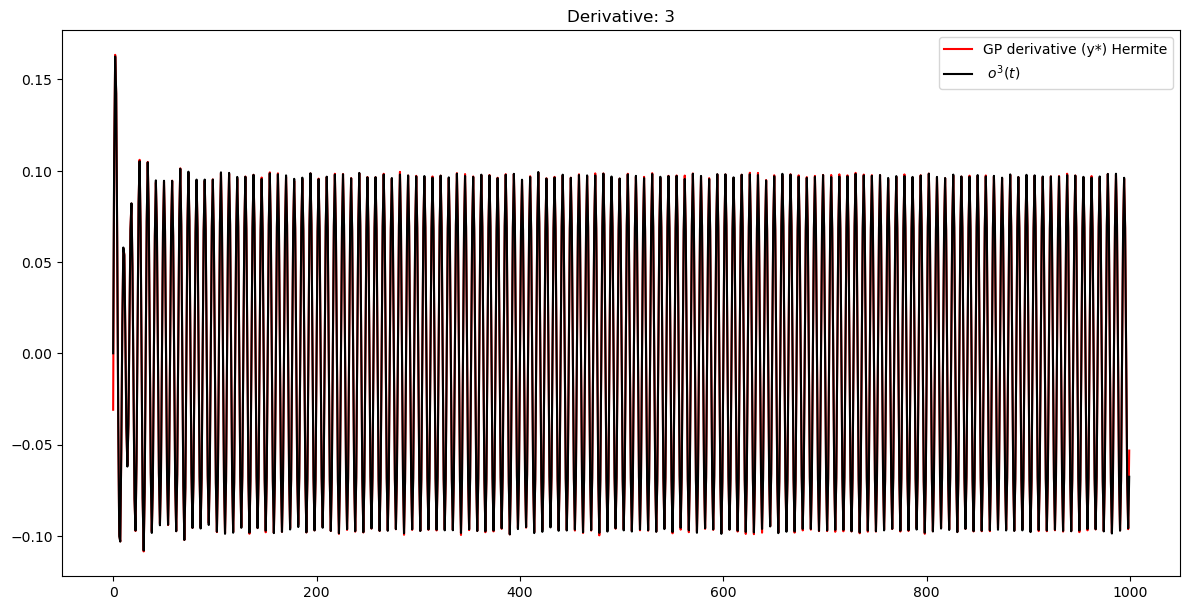

100%|██████████| 1000/1000 [00:00<00:00, 3494.08it/s]


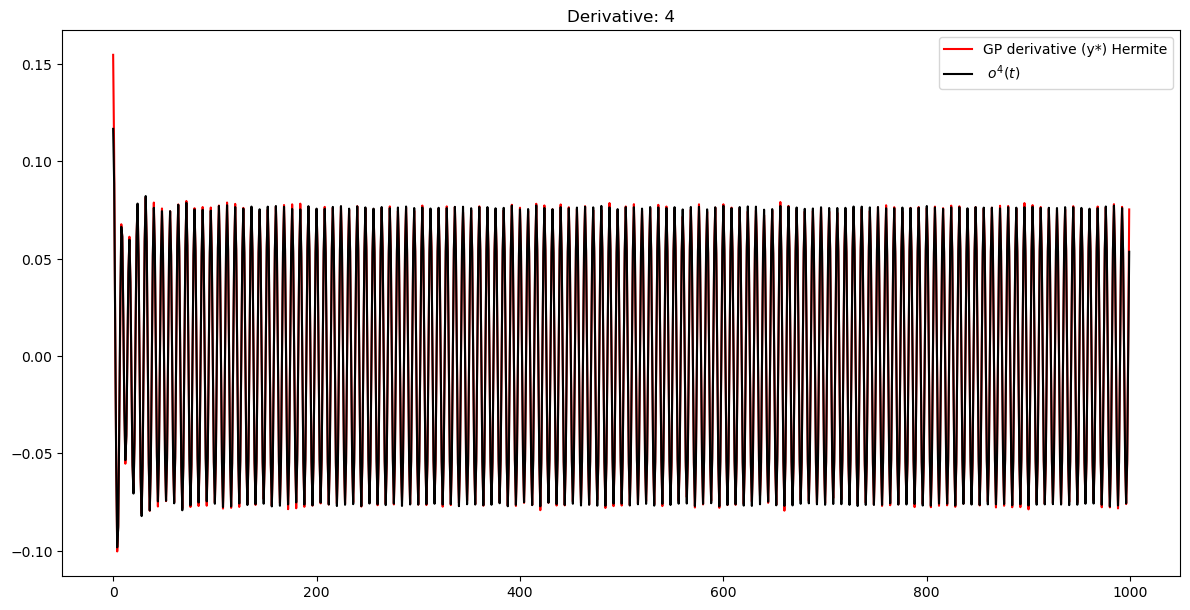

100%|██████████| 1000/1000 [00:00<00:00, 3699.13it/s]


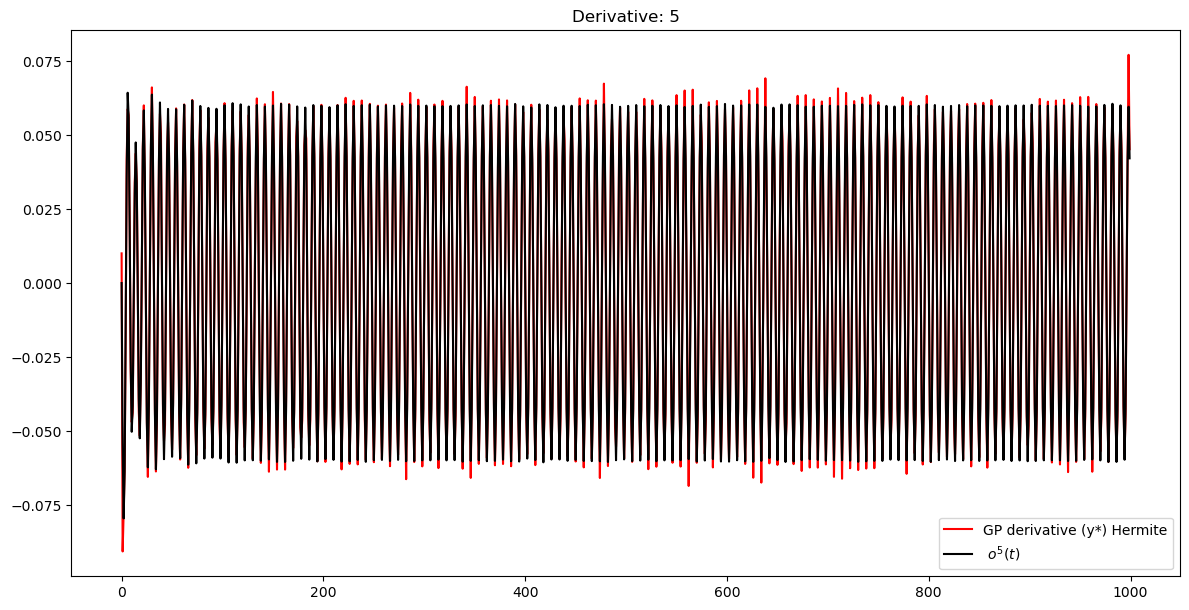

100%|██████████| 1000/1000 [00:00<00:00, 3444.42it/s]


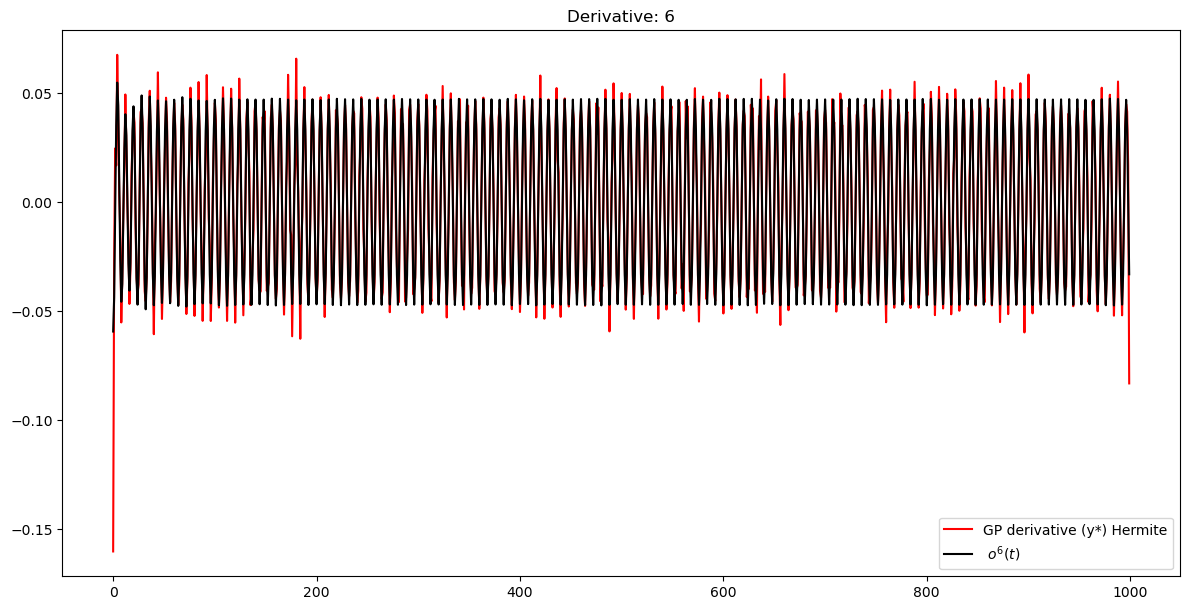

100%|██████████| 1000/1000 [00:00<00:00, 3532.27it/s]


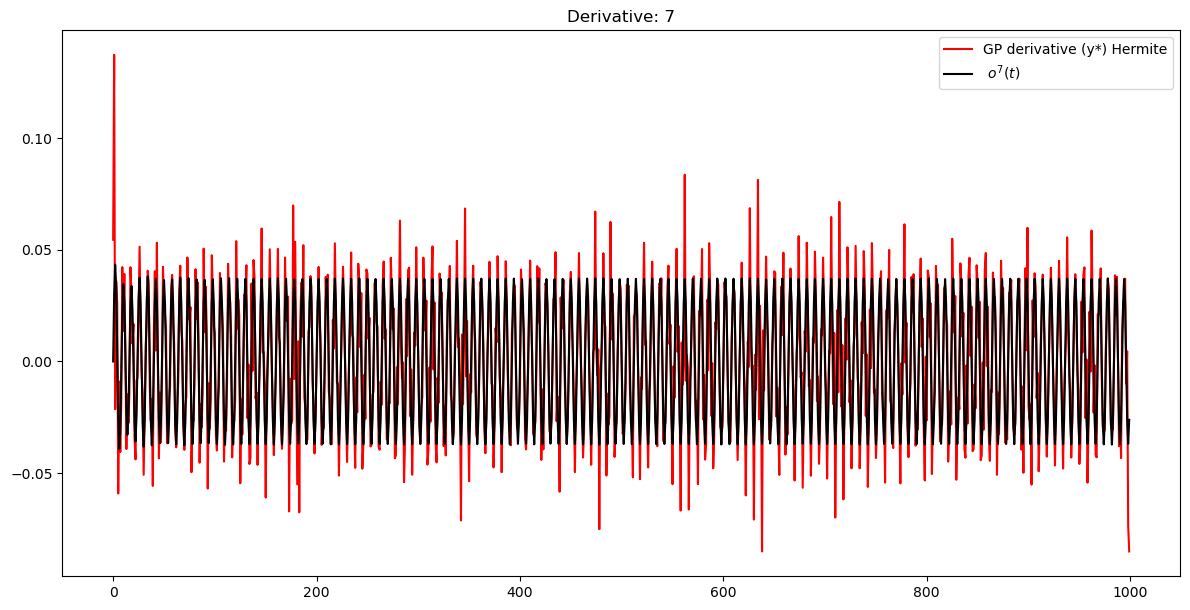

100%|██████████| 1000/1000 [00:00<00:00, 3197.87it/s]


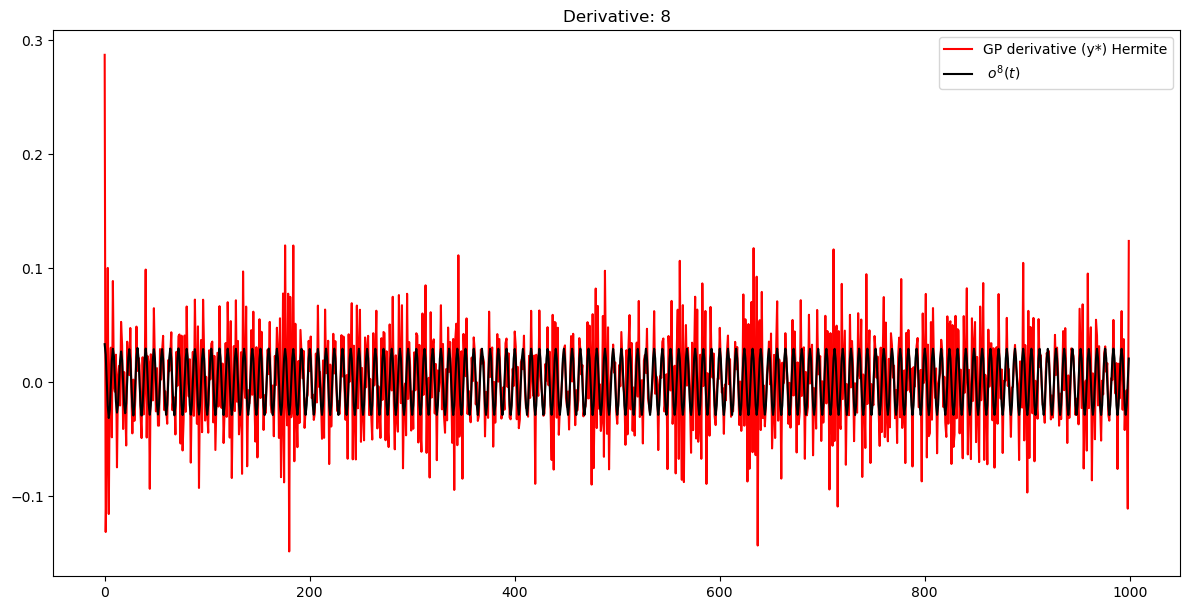

100%|██████████| 1000/1000 [00:00<00:00, 3255.16it/s]


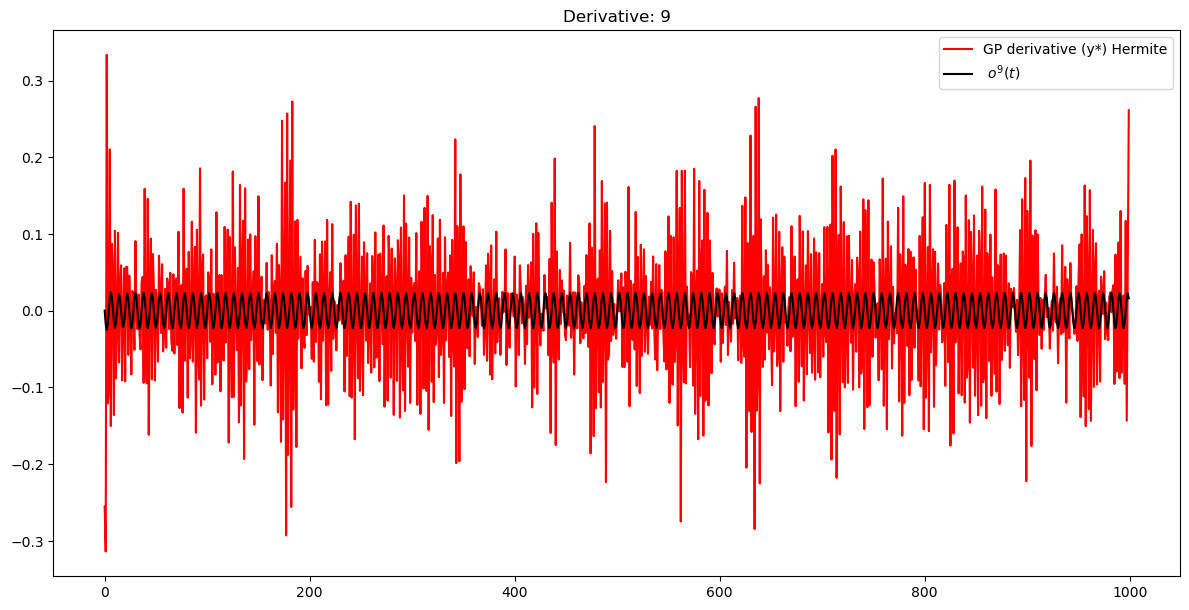

100%|██████████| 1000/1000 [00:00<00:00, 3213.51it/s]


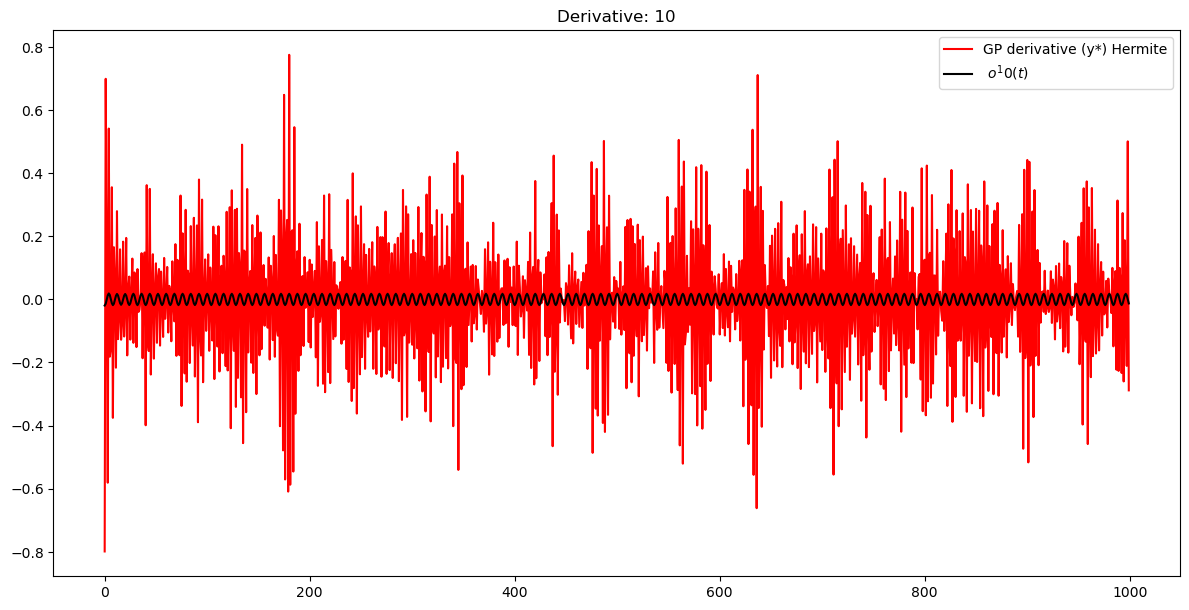

In [62]:
for i in range(0, 11):
    sample_dataS = generate_samples_der(Et,phi,dt,Tmax, n=i)
    herm = drbf(i, t1mt2, l=computed_length_scale).reshape((Tmax, Tmax))
    dy_dt_star_herm = np.dot(herm, K_inv @ y)
    plt.figure(figsize=(12, 6))
    plt.plot(t, dy_dt_star_herm, label="GP derivative (y*) Hermite", color='red')
    plt.plot(t, sample_dataS.real, label=r' $o^'+str(i)+'(t)$', color='black')
    
  
    plt.legend()
    plt.tight_layout()
    plt.title('Derivative: ' +str(i))
    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 5715.46it/s]


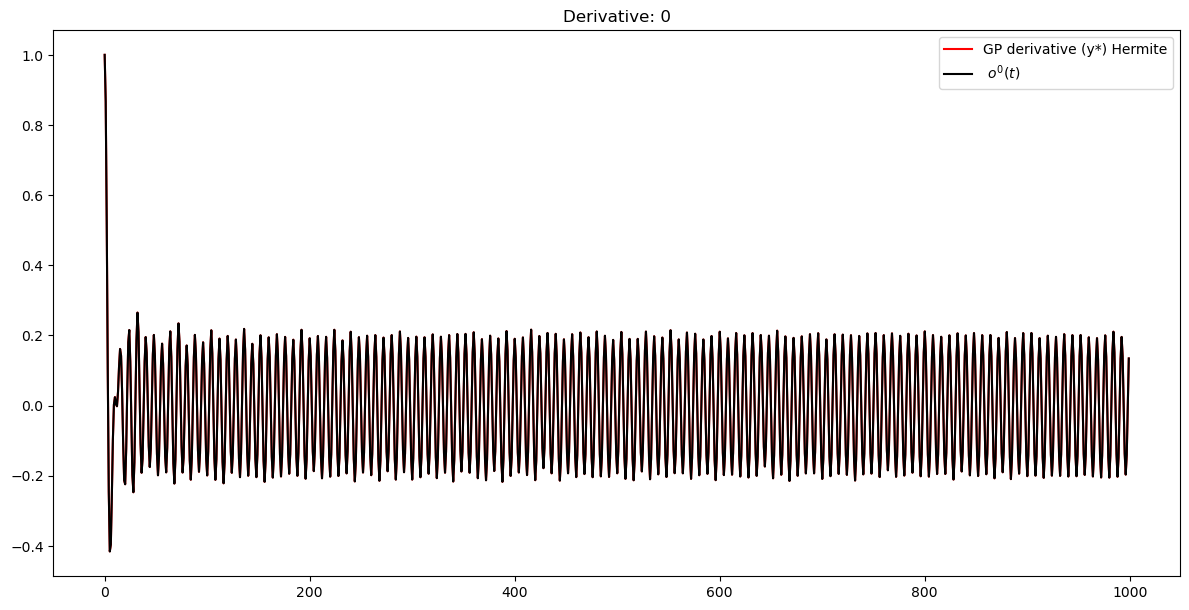

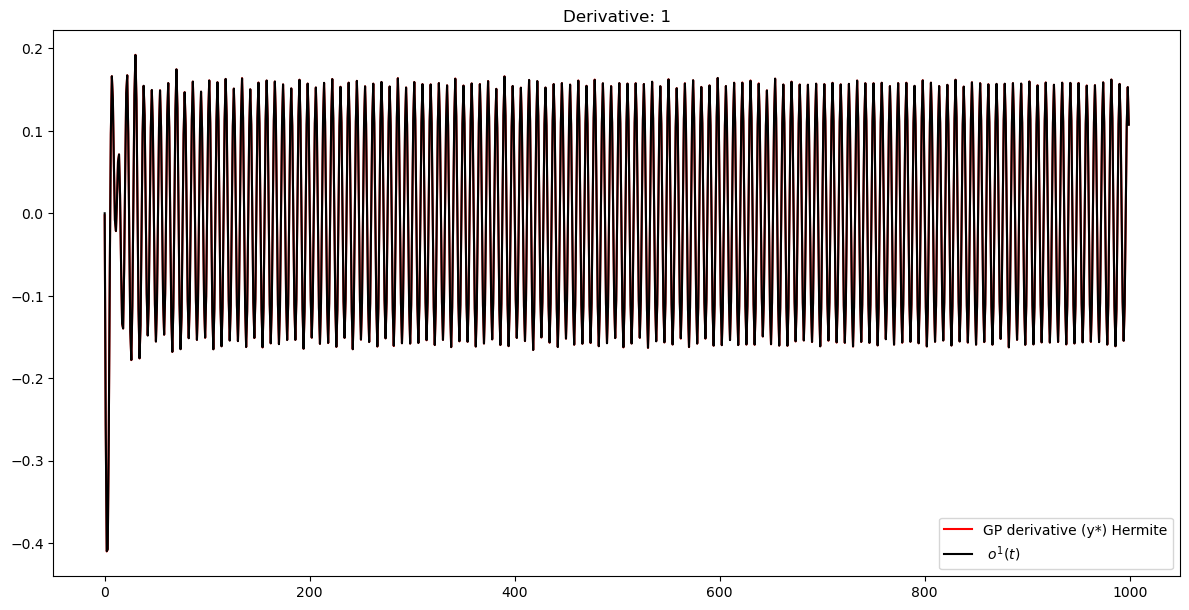

In [63]:
dy_dt_star_herms = []
for i in range(2):
    nder = i
    sample_dataS = generate_samples_der(Et,phi,dt,Tmax, n=nder)
    herm = drbf(nder, t1mt2, l=computed_length_scale).reshape((Tmax, Tmax))
    dy_dt_star_herm = np.dot(herm, K_inv @ y)
    plt.figure(figsize=(12, 6))
    plt.plot(t, dy_dt_star_herm, label="GP derivative (y*) Hermite", color='red')
    plt.plot(t, sample_dataS.real, label=r' $o^'+str(i)+'(t)$', color='black')
    
  
    plt.legend()
    plt.tight_layout()
    plt.title('Derivative: ' +str(i))
    dy_dt_star_herms.append(dy_dt_star_herm)

In [64]:
dy_dt_star_herms = np.array(dy_dt_star_herms)

In [65]:
dy_dt_star_herms.T[0,0] = 1.0
dy_dt_star_herms.T

array([[ 1.        , -0.00248847],
       [ 0.86727339, -0.25590399],
       [ 0.52221508, -0.41024928],
       ...,
       [-0.1409405 ,  0.1079701 ],
       [-0.00310763,  0.15295842],
       [ 0.13412344,  0.10784116]])

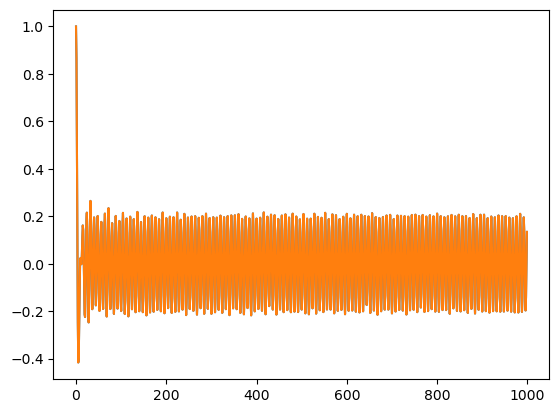

In [66]:
plt.plot(dy_dt_star_herms.T[:, 0])
plt.plot(dataS.real)

In [67]:
np.mean(np.abs(dy_dt_star_herms.T[:, 0] - dataS.real))

7.321677385074982e-05

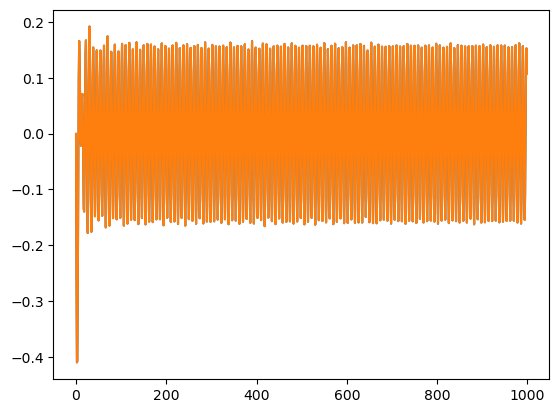

In [68]:
plt.plot(dy_dt_star_herms.T[:, 1])
plt.plot(ddataS.real)

In [69]:
np.mean(np.abs(dy_dt_star_herms.T[:,1] - ddataS.real))

0.00011095055443501146

In [70]:
dataS_first_der = generate_samples_der(Et,phi,dt,Tmax, n=1)

100%|██████████| 1000/1000 [00:00<00:00, 6178.22it/s]


In [71]:
dataS_zero_der = generate_samples_der(Et,phi,dt,Tmax, n=0)

100%|██████████| 1000/1000 [00:00<00:00, 6130.48it/s]


In [72]:
dataS_second_der = generate_samples_der(Et, phi, dt, Tmax, n=2)

100%|██████████| 1000/1000 [00:00<00:00, 6074.91it/s]


In [126]:
# outE0 = dataS_second_der + Et[0].item()*dataS_zero_der + dataS_first_der + (1j*Et[0].item())*dataS_zero_der
pred_lam = Et[0].item()
outE0 = (dy_dt_star_herms.T[:, 1] + ((1j*pred_lam)*(dataS_zero_der + 1e-1*np.random.randn(dataS_zero_der.shape[0]) ) ))/pred_lam

In [127]:
# outE0 = dataS_second_der + Et[0].item()*dataS_zero_der + dataS_first_der + (1j*Et[0].item())*dataS_zero_der
pred_lam_true = Et[0].item()
outE0_true = (dataS_first_der + ((1j*pred_lam_true)*dataS_zero_der))/pred_lam_true

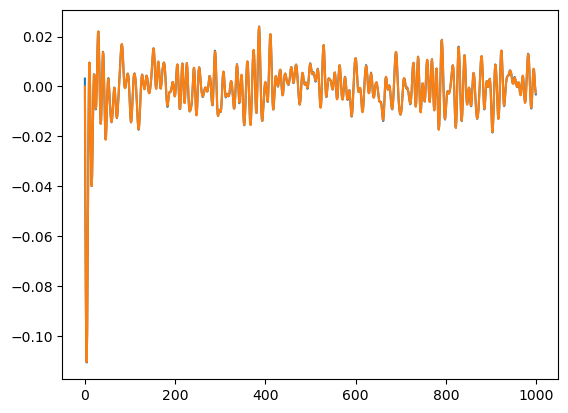

In [128]:
plt.plot(outE0.real)
plt.plot(outE0_true.real)

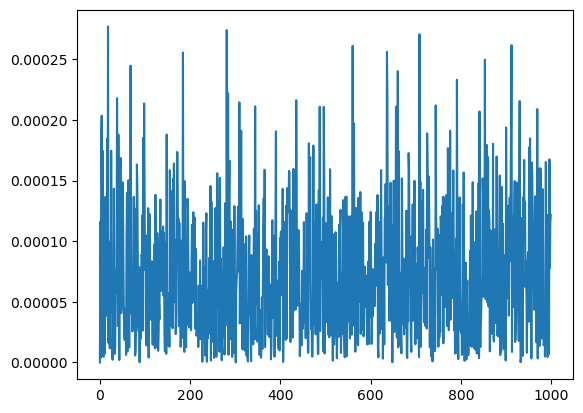

In [129]:
plt.plot(np.abs(dataS_zero_der.real - dy_dt_star_herms.T[:, 0] ))

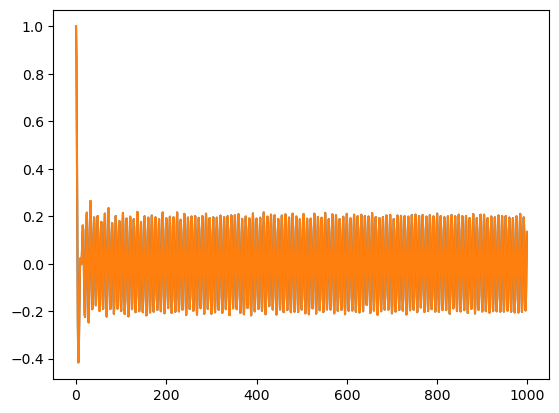

In [76]:
plt.plot(dataS_zero_der.real)
plt.plot(dy_dt_star_herms.T[:, 0])

In [77]:
# from scipy.io import savemat
# savemat('../../matlab/denoised_data/denoised_dataS_LiH_true_projected_E0_Tmax' + str(Tmax) + '_overlap_ground_state=' + str(overlap) + 'noise=' + str(noise) + '_dt=1_der=1_normalized_complex.mat', {'denoised_dataS': outE0_true})

In [78]:
dy_dt_star_herms.T, dy_dt_star_herms.T.flatten()

(array([[ 1.        , -0.00248847],
        [ 0.86727339, -0.25590399],
        [ 0.52221508, -0.41024928],
        ...,
        [-0.1409405 ,  0.1079701 ],
        [-0.00310763,  0.15295842],
        [ 0.13412344,  0.10784116]]),
 array([ 1.        , -0.00248847,  0.86727339, ...,  0.15295842,
         0.13412344,  0.10784116]))

In [84]:
from scipy.io import savemat
savemat('../../matlab/denoised_data/denoised_dataS_Cr2_Tmax' + str(Tmax) + 'noise=' + str(noise) + '_dt=1_der=1_real.mat', {'denoised_dataS': dy_dt_star_herms.T.flatten()})

In [80]:
phi**2

array([[0.2       ],
       [0.00026774],
       [0.00026774],
       ...,
       [0.00026774],
       [0.00026774],
       [0.00026774]])

In [84]:
(np.sqrt(1 - overlap)/np.sqrt(len(E)))**2

0.0002676480428236868

In [106]:
phi**2

array([[0.00026774],
       [0.2       ],
       [0.00026774],
       ...,
       [0.00026774],
       [0.00026774],
       [0.00026774]])